## Architecture Specifications
**Network Structure**
```
Input Layer:     784 neurons (28×28 flattened images)
Hidden Layer 1:  512 neurons + Leaky ReLU (α=0.01) + Dropout(0.2)
Hidden Layer 2:  256 neurons + Leaky ReLU (α=0.01) + Dropout(0.2)
Hidden Layer 3:  128 neurons + Leaky ReLU (α=0.01) + Dropout(0.3)
Hidden Layer 4:  64 neurons + Leaky ReLU (α=0.01) + Dropout(0.3)
Output Layer:    10 neurons + Softmax
```

**Training Configuration**
- **Optimizer**: Adam (β₁=0.9, β₂=0.999, lr=0.001, ε=1e-8)
- **Loss Function**: Categorical Cross-Entropy + L2 Regularization (λ=0.01)
- **Batch Size**: 64
- **Weight Initialization**: He Initialization
- **Early Stopping**: Patience=15 epochs on dev set accuracy
- **Max Epochs**: 150

## Section 1: Imports and Configuration

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
from typing import Tuple, Dict, List, Optional

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# Configuration dictionary with all hyperparameters
CONFIG = {
    'architecture': [784, 512, 256, 128, 64, 10],
    'learning_rate': 0.001,
    'beta1': 0.9,
    'beta2': 0.999,
    'epsilon': 1e-8,
    'lambda_reg': 0.01,
    'dropout_rates': [0.2, 0.2, 0.3, 0.3],
    'leaky_alpha': 0.005,
    'batch_size': 128,
    'max_epochs': 50,
    'patience': 15,
    'seed': 42,
    'train_path': 'fashion-mnist_train.csv',  # Adjusting for actual filename found on disk
    'test_path': 'fashion-mnist_test.csv'     # Adjusting for actual filename found on disk
}

CLASS_NAMES = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat','Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


## Section 2: Data Loading and Preprocessing

In [3]:
class DataLoader:
    
    def __init__(self, train_path: str, test_path: str, seed: int = 42):
        self.train_path = train_path
        self.test_path = test_path
        self.seed = seed
    
    def load_and_preprocess(self) -> Tuple[np.ndarray, np.ndarray, np.ndarray, 
                                           np.ndarray, np.ndarray, np.ndarray]:
        # Check if files exist
        if not os.path.exists(self.train_path) or not os.path.exists(self.test_path):
            raise FileNotFoundError(f"Data files not found. Expected {self.train_path} and {self.test_path}")

        # Load CSVs
        print(f"Loading {self.train_path}...")
        train_df = pd.read_csv(self.train_path)
        print(f"Loading {self.test_path}...")
        test_df = pd.read_csv(self.test_path)
        
        # Extract labels and pixels
        train_labels = train_df['label'].values
        train_pixels = train_df.drop('label', axis=1).values.astype(np.float32)
        test_labels = test_df['label'].values
        test_pixels = test_df.drop('label', axis=1).values.astype(np.float32)
        
        # Normalize pixels [0, 255] -> [0, 1]
        train_pixels = train_pixels / 255.0
        test_pixels = test_pixels / 255.0
        
        # Train/Dev split (80/20)
        np.random.seed(self.seed)
        n_samples = len(train_labels)
        indices = np.random.permutation(n_samples)
        split_idx = int(0.8 * n_samples)
        
        train_idx, dev_idx = indices[:split_idx], indices[split_idx:]
        
        # Transpose to (features, samples)
        X_train = train_pixels[train_idx].T  # (784, 48000)
        Y_train = self._one_hot(train_labels[train_idx])  # (10, 48000)
        X_dev = train_pixels[dev_idx].T  # (784, 12000)
        Y_dev = self._one_hot(train_labels[dev_idx])  # (10, 12000)
        X_test = test_pixels.T  # (784, 10000)
        Y_test = self._one_hot(test_labels)  # (10, 10000)
        
        return X_train, Y_train, X_dev, Y_dev, X_test, Y_test
    
    def _one_hot(self, labels: np.ndarray) -> np.ndarray:
        """Convert labels to one-hot encoding."""
        n_classes = 10
        one_hot = np.zeros((n_classes, len(labels)), dtype=np.float32)
        one_hot[labels, np.arange(len(labels))] = 1.0
        return one_hot

# Load data
loader = DataLoader(CONFIG['train_path'], CONFIG['test_path'], CONFIG['seed'])
try:
    X_train, Y_train, X_dev, Y_dev, X_test, Y_test = loader.load_and_preprocess()
    
    # Verify shapes
    print(f'X_train: {X_train.shape}, Y_train: {Y_train.shape}')
    print(f'X_dev: {X_dev.shape}, Y_dev: {Y_dev.shape}')
    print(f'X_test: {X_test.shape}, Y_test: {Y_test.shape}')
    
    assert X_train.shape == (784, 48000)
    assert Y_train.shape == (10, 48000)
    assert X_dev.shape == (784, 12000)
    assert X_test.shape == (784, 10000)
    print('Data loaded and verified successfully!')

except FileNotFoundError as e:
    print(e)
    print("Please ensure the CSV files are in the same directory as this notebook.")

Loading fashion-mnist_train.csv...
Loading fashion-mnist_test.csv...
X_train: (784, 48000), Y_train: (10, 48000)
X_dev: (784, 12000), Y_dev: (10, 12000)
X_test: (784, 10000), Y_test: (10, 10000)
Data loaded and verified successfully!


## Section 3: Activation Functions

In [4]:
class LeakyReLU:
    """Leaky ReLU activation with configurable alpha."""
    
    def __init__(self, alpha: float = 0.01):
        self.alpha = alpha
        self.cache = None
    
    def forward(self, Z: np.ndarray) -> np.ndarray:
        self.cache = Z
        return np.where(Z > 0, Z, self.alpha * Z)
    
    def backward(self, dA: np.ndarray) -> np.ndarray:
        Z = self.cache
        dZ = np.where(Z > 0, 1.0, self.alpha)
        return dA * dZ


class Softmax:
    """Numerically stable softmax activation."""
    
    def __init__(self):
        self.cache = None
    
    def forward(self, Z: np.ndarray) -> np.ndarray:
        # Subtract max for numerical stability to prevent overflow
        Z_shifted = Z - np.max(Z, axis=0, keepdims=True)
        exp_Z = np.exp(Z_shifted)
        A = exp_Z / np.sum(exp_Z, axis=0, keepdims=True)
        self.cache = A
        return A

print('Activation functions defined')

Activation functions defined


## Section 4: Layer Components

In [5]:
class Dense:
    """Fully connected layer with He initialization."""
    
    def __init__(self, n_in: int, n_out: int):
        # He Initialization
        self.W = np.random.randn(n_out, n_in).astype(np.float32) * np.sqrt(2.0 / n_in)
        self.b = np.zeros((n_out, 1), dtype=np.float32)
        self.cache = None
        self.dW = None
        self.db = None
    
    def forward(self, X: np.ndarray) -> np.ndarray:
        self.cache = X
        # Z = W @ X + b
        return self.W @ X + self.b
    
    def backward(self, dZ: np.ndarray, lambda_reg: float = 0.0) -> np.ndarray:
        X = self.cache
        m = X.shape[1]
        
        # Calculate gradients
        # dW includes L2 regularization term (derivative of (lambda/2)*sum(W^2) is lambda*W)
        self.dW = (dZ @ X.T) / m + lambda_reg * self.W
        self.db = np.sum(dZ, axis=1, keepdims=True) / m
        
        # Return gradients for previous layer
        return self.W.T @ dZ


class Dropout:
    """Dropout layer with inverted dropout scaling."""
    
    def __init__(self, rate: float = 0.3):
        self.rate = rate
        self.mask = None
    
    def forward(self, A: np.ndarray, training: bool = True) -> np.ndarray:
        if not training or self.rate == 0:
            return A
        
        # Inverted dropout: Scale during training so no scaling needed at test time
        self.mask = (np.random.rand(*A.shape) > self.rate).astype(np.float32) / (1 - self.rate)
        return A * self.mask
    
    def backward(self, dA: np.ndarray) -> np.ndarray:
        if self.mask is None:
            return dA
        return dA * self.mask

print('Layer components defined')

Layer components defined


## Section 5: Neural Network

In [6]:
class NeuralNetwork:
    """Deep neural network with Leaky ReLU, Dropout, and Softmax output."""
    
    def __init__(self, architecture: List[int], dropout_rates: List[float], 
                 leaky_alpha: float = 0.01):
        self.layers = []
        self.activations = []
        self.dropouts = []
        self.softmax = Softmax()
        
        # Build hidden layers
        # Architecture: [784, 256, 128, 64, 32, 10]
        for i in range(len(architecture) - 1):
            self.layers.append(Dense(architecture[i], architecture[i+1]))
            
            # Add activation and dropout for all but the last layer
            if i < len(architecture) - 2:  
                self.activations.append(LeakyReLU(leaky_alpha))
                self.dropouts.append(Dropout(dropout_rates[i]))
        
        self.cache = {}
    
    def forward(self, X: np.ndarray, training: bool = True) -> np.ndarray:
        A = X
        self.cache['A0'] = A
        
        # Forward pass through hidden layers
        for i, layer in enumerate(self.layers[:-1]):
            Z = layer.forward(A)
            self.cache[f'Z{i+1}'] = Z
            
            A = self.activations[i].forward(Z)
            self.cache[f'A{i+1}_pre'] = A
            
            A = self.dropouts[i].forward(A, training)
            self.cache[f'A{i+1}'] = A
        
        # Output layer
        Z = self.layers[-1].forward(A)
        self.cache['Z_out'] = Z
        A = self.softmax.forward(Z)
        self.cache['A_out'] = A
        return A
    
    def backward(self, Y: np.ndarray, lambda_reg: float = 0.0) -> None:
        A_out = self.cache['A_out']
        
        # Gradient of Cross-Entropy + Softmax
        dZ = A_out - Y
        
        # Output layer backward
        n_layers = len(self.layers)
        dA = self.layers[-1].backward(dZ, lambda_reg)
        
        # Hidden layers backward (in reverse order)
        for i in range(n_layers - 2, -1, -1):
            dA = self.dropouts[i].backward(dA)
            dA = self.activations[i].backward(dA)
            dA = self.layers[i].backward(dA, lambda_reg)
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        # Predict mode disables dropout
        return self.forward(X, training=False)

print('Neural Network class defined')

Neural Network class defined


## Section 6: Adam Optimizer

In [7]:
class AdamOptimizer:
    """Adam optimizer with bias correction."""
    
    def __init__(self, network: NeuralNetwork, lr: float = 0.001,
                 beta1: float = 0.9, beta2: float = 0.999, epsilon: float = 1e-8):
        self.network = network
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.t = 0
        
        # Initialize moment estimates
        self.m_W = [np.zeros_like(layer.W) for layer in network.layers]
        self.v_W = [np.zeros_like(layer.W) for layer in network.layers]
        self.m_b = [np.zeros_like(layer.b) for layer in network.layers]
        self.v_b = [np.zeros_like(layer.b) for layer in network.layers]
    
    def update(self) -> None:
        self.t += 1
        
        for i, layer in enumerate(self.network.layers):
            # Update Weights
            self.m_W[i] = self.beta1 * self.m_W[i] + (1 - self.beta1) * layer.dW
            self.v_W[i] = self.beta2 * self.v_W[i] + (1 - self.beta2) * (layer.dW ** 2)
            
            # Bias correction
            m_hat_W = self.m_W[i] / (1 - self.beta1 ** self.t)
            v_hat_W = self.v_W[i] / (1 - self.beta2 ** self.t)
            
            # Parameter update
            layer.W -= self.lr * m_hat_W / (np.sqrt(v_hat_W) + self.epsilon)
            
            # Update Biases
            self.m_b[i] = self.beta1 * self.m_b[i] + (1 - self.beta1) * layer.db
            self.v_b[i] = self.beta2 * self.v_b[i] + (1 - self.beta2) * (layer.db ** 2)
            
            # Bias correction
            m_hat_b = self.m_b[i] / (1 - self.beta1 ** self.t)
            v_hat_b = self.v_b[i] / (1 - self.beta2 ** self.t)
            
            # Parameter update
            layer.b -= self.lr * m_hat_b / (np.sqrt(v_hat_b) + self.epsilon)

print('Adam Optimizer defined')

Adam Optimizer defined


## Section 7: Loss Functions and Metrics

In [8]:
def cross_entropy_loss(Y_pred: np.ndarray, Y_true: np.ndarray) -> float:
    """Categorical cross-entropy loss."""
    epsilon = 1e-8
    # Standard cross-entropy formula
    return -np.mean(np.sum(Y_true * np.log(Y_pred + epsilon), axis=0))


def l2_regularization(network: NeuralNetwork, lambda_reg: float) -> float:
    """L2 regularization term (weights only)."""
    reg_sum = sum(np.sum(layer.W ** 2) for layer in network.layers)
    return (lambda_reg / 2) * reg_sum


def compute_accuracy(Y_pred: np.ndarray, Y_true: np.ndarray) -> float:
    """Compute classification accuracy."""
    pred_labels = np.argmax(Y_pred, axis=0)
    true_labels = np.argmax(Y_true, axis=0)
    return np.mean(pred_labels == true_labels) * 100


def confusion_matrix(Y_pred: np.ndarray, Y_true: np.ndarray, n_classes: int = 10) -> np.ndarray:
    """Compute confusion matrix."""
    pred_labels = np.argmax(Y_pred, axis=0)
    true_labels = np.argmax(Y_true, axis=0)
    cm = np.zeros((n_classes, n_classes), dtype=int)
    for t, p in zip(true_labels, pred_labels):
        cm[t, p] += 1
    return cm


def per_class_accuracy(cm: np.ndarray, class_names: List[str]) -> Dict[str, float]:
    """Compute per-class accuracy from confusion matrix."""
    accuracies = {}
    for i, name in enumerate(class_names):
        total = cm[i].sum()
        correct = cm[i, i]
        accuracies[name] = (correct / total * 100) if total > 0 else 0.0
    return accuracies

print('Loss functions and metrics defined')

Loss functions and metrics defined


## Section 8: Training Loop

In [9]:
class Trainer:
    """Training loop with mini-batches and early stopping."""
    
    def __init__(self, network: NeuralNetwork, optimizer: AdamOptimizer, config: Dict):
        self.network = network
        self.optimizer = optimizer
        self.config = config
        self.history = {'loss': [], 'train_acc': [], 'dev_loss': [], 'dev_acc': [], 'test_loss': [], 'test_acc': []}
        self.best_weights = None
        self.best_dev_acc = 0
        self.best_epoch = 0
    
    def _create_batches(self, X: np.ndarray, Y: np.ndarray) -> List[Tuple[np.ndarray, np.ndarray]]:
        m = X.shape[1]
        batch_size = self.config['batch_size']
        indices = np.random.permutation(m)
        X_shuffled = X[:, indices]
        Y_shuffled = Y[:, indices]
        
        batches = []
        for i in range(0, m, batch_size):
            X_batch = X_shuffled[:, i:i+batch_size]
            Y_batch = Y_shuffled[:, i:i+batch_size]
            batches.append((X_batch, Y_batch))
        return batches
    
    def _save_weights(self):
        self.best_weights = [(layer.W.copy(), layer.b.copy()) for layer in self.network.layers]
    
    def _restore_weights(self):
        for i, layer in enumerate(self.network.layers):
            layer.W = self.best_weights[i][0].copy()
            layer.b = self.best_weights[i][1].copy()
    
    def train_epoch(self, X: np.ndarray, Y: np.ndarray) -> float:
        batches = self._create_batches(X, Y)
        epoch_loss = 0
        
        for X_batch, Y_batch in batches:
            # Forward
            Y_pred = self.network.forward(X_batch, training=True)
            
            # Compute loss
            loss = cross_entropy_loss(Y_pred, Y_batch)
            loss += l2_regularization(self.network, self.config['lambda_reg'])
            epoch_loss += loss * X_batch.shape[1]
            
            # Backward
            self.network.backward(Y_batch, self.config['lambda_reg'])
            
            # Update
            self.optimizer.update()
        
        return epoch_loss / X.shape[1]
    
    def evaluate(self, X: np.ndarray, Y: np.ndarray) -> Tuple[float, float]:
        Y_pred = self.network.predict(X)
        loss = cross_entropy_loss(Y_pred, Y)
        loss += l2_regularization(self.network, self.config['lambda_reg'])
        acc = compute_accuracy(Y_pred, Y)
        return loss, acc
    
    def fit(self, X_train: np.ndarray, Y_train: np.ndarray,
            X_dev: np.ndarray, Y_dev: np.ndarray,
            X_test: np.ndarray, Y_test: np.ndarray) -> Dict:
        
        patience_counter = 0
        
        print('=' * 60)
        print('TRAINING FASHION MNIST NEURAL NETWORK')
        print('=' * 60)
        arch_str = ' -> '.join(map(str, self.config['architecture']))
        print(f'Architecture: {arch_str}')
        print(f'Training samples: {X_train.shape[1]:,}')
        print(f'Dev samples: {X_dev.shape[1]:,}')
        print()
        
        for epoch in range(1, self.config['max_epochs'] + 1):
            start_time = time.time()
            
            # Train
            train_loss = self.train_epoch(X_train, Y_train)
            
            # Evaluate
            _, train_acc = self.evaluate(X_train, Y_train)
            dev_loss, dev_acc = self.evaluate(X_dev, Y_dev)
            test_loss, test_acc = self.evaluate(X_test, Y_test)
            
            # Record history
            self.history['loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['dev_loss'].append(dev_loss)
            self.history['dev_acc'].append(dev_acc)
            self.history['test_loss'].append(test_loss)
            self.history['test_acc'].append(test_acc)
            
            elapsed = time.time() - start_time
            
            print(f'Epoch {epoch:03d}/{self.config["max_epochs"]} | '
                  f'Loss: {train_loss:.4f} | Train Acc: {train_acc:.1f}% | '
                  f'Dev Acc: {dev_acc:.1f}% | Time: {elapsed:.1f}s')
            
            # Early stopping check
            if dev_acc > self.best_dev_acc:
                self.best_dev_acc = dev_acc
                self.best_epoch = epoch
                self._save_weights()
                patience_counter = 0
            else:
                patience_counter += 1
            
            if patience_counter >= self.config['patience']:
                print(f'\nEarly stopping triggered at epoch {epoch}')
                break
        
        print(f'Best dev accuracy: {self.best_dev_acc:.1f}% (epoch {self.best_epoch})')
        self._restore_weights()
        
        return self.history

print('Trainer class defined')

Trainer class defined


## Section 9: Main Execution

Initial loss (should be ~2.3): 2.6450
TRAINING FASHION MNIST NEURAL NETWORK
Architecture: 784 -> 512 -> 256 -> 128 -> 64 -> 10
Training samples: 48,000
Dev samples: 12,000

Epoch 001/50 | Loss: 3.5761 | Train Acc: 81.6% | Dev Acc: 81.7% | Time: 39.0s
Epoch 002/50 | Loss: 1.1587 | Train Acc: 80.3% | Dev Acc: 79.8% | Time: 45.4s
Epoch 003/50 | Loss: 0.9797 | Train Acc: 83.2% | Dev Acc: 82.8% | Time: 63.7s
Epoch 004/50 | Loss: 0.9394 | Train Acc: 82.3% | Dev Acc: 82.0% | Time: 60.5s
Epoch 005/50 | Loss: 0.9229 | Train Acc: 82.4% | Dev Acc: 82.0% | Time: 52.7s
Epoch 006/50 | Loss: 0.9084 | Train Acc: 82.3% | Dev Acc: 82.1% | Time: 39.8s
Epoch 007/50 | Loss: 0.9007 | Train Acc: 82.8% | Dev Acc: 82.5% | Time: 42.7s
Epoch 008/50 | Loss: 0.8857 | Train Acc: 83.6% | Dev Acc: 83.0% | Time: 41.0s
Epoch 009/50 | Loss: 0.8829 | Train Acc: 82.8% | Dev Acc: 82.3% | Time: 35.8s
Epoch 010/50 | Loss: 0.8729 | Train Acc: 84.0% | Dev Acc: 83.4% | Time: 39.9s
Epoch 011/50 | Loss: 0.8657 | Train Acc: 82.7% 

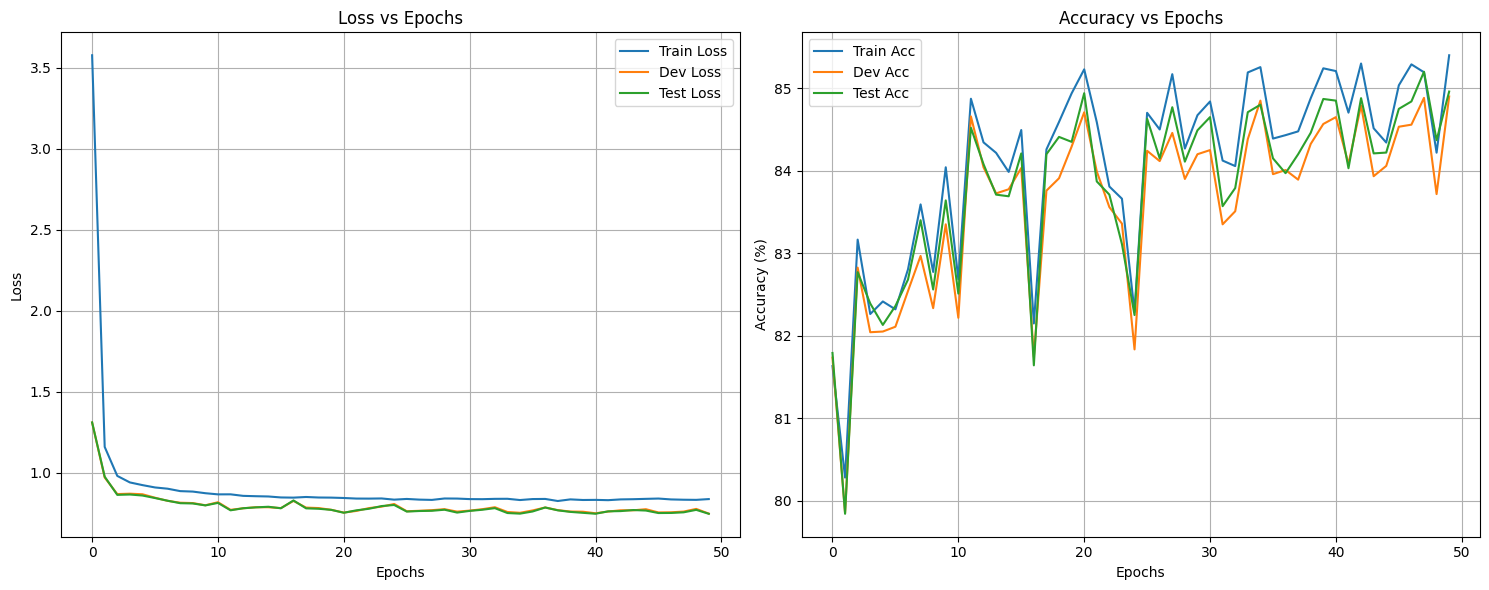

In [10]:
# Initialize network
np.random.seed(CONFIG['seed'])
network = NeuralNetwork(
    architecture=CONFIG['architecture'],
    dropout_rates=CONFIG['dropout_rates'],
    leaky_alpha=CONFIG['leaky_alpha']
)

# Initialize optimizer
optimizer = AdamOptimizer(
    network=network,
    lr=CONFIG['learning_rate'],
    beta1=CONFIG['beta1'],
    beta2=CONFIG['beta2'],
    epsilon=CONFIG['epsilon']
)

# Initialize trainer
trainer = Trainer(network, optimizer, CONFIG)

# Sanity check and start training only if data was loaded
if 'X_train' in globals():
    # Sanity check: initial loss should be ~2.3 (-log(1/10))
    initial_pred = network.predict(X_train[:, :100])
    initial_loss = cross_entropy_loss(initial_pred, Y_train[:, :100])
    print(f'Initial loss (should be ~2.3): {initial_loss:.4f}')

    # Run Training
    history = trainer.fit(X_train, Y_train, X_dev, Y_dev, X_test, Y_test)

    # Plotting
    plt.figure(figsize=(15, 6))
    
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['dev_loss'], label='Dev Loss')
    plt.plot(history['test_loss'], label='Test Loss')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['dev_acc'], label='Dev Acc')
    plt.plot(history['test_acc'], label='Test Acc')
    plt.title('Accuracy vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
else:
    print("Skipping training due to missing data.")

    
    # Plot Loss
    
    # Plot Accuracy
    


## Section 10: Final Test Evaluation and Results

In [11]:
if 'X_test' in globals() and trainer.best_weights is not None:
    print('=' * 60)
    print('FINAL TEST SET EVALUATION')
    print('=' * 60)

    # Final evaluation on test set
    Y_test_pred = network.predict(X_test)
    test_loss = cross_entropy_loss(Y_test_pred, Y_test)
    test_acc = compute_accuracy(Y_test_pred, Y_test)

    print(f'Test Accuracy: {test_acc:.1f}%')
    print(f'Test Loss: {test_loss:.4f}')
    print()

    # Confusion Matrix
    cm = confusion_matrix(Y_test_pred, Y_test)
    print('Confusion Matrix:')
    header = '      ' + ''.join(f'{i:>5}' for i in range(10))
    print(header)
    for i in range(10):
        row = f'{i:>3}  [' + ''.join(f'{cm[i,j]:>4} ' for j in range(10)) + ']'
        print(row)
    print()

    # Per-class accuracy
    class_acc = per_class_accuracy(cm, CLASS_NAMES)
    print('Per-Class Accuracy:')
    for name, acc in class_acc.items():
        print(f'  {name:12s}: {acc:.1f}%')
    print()

    # Most confused pairs
    print('Most Confused Pairs (Top 5):')
    confused = []
    for i in range(10):
        for j in range(10):
            if i != j:
                # Total mistakes between i and j
                total = cm[i, j] + cm[j, i]
                if total > 0:
                    confused.append((CLASS_NAMES[i], CLASS_NAMES[j], total))

    # Remove duplicates (e.g., A<->B is same as B<->A) and sort
    seen = set()
    unique_confused = []
    for a, b, c in sorted(confused, key=lambda x: -x[2]):
        pair = tuple(sorted([a, b]))
        if pair not in seen:
            seen.add(pair)
            unique_confused.append((a, b, c))

    for i, (a, b, count) in enumerate(unique_confused[:5], 1):
        print(f'  {i}. {a} <-> {b}: {count} mistakes')

    print()
    print('=' * 60)
    print('TRAINING COMPLETE')
    print('=' * 60)

FINAL TEST SET EVALUATION


Test Accuracy: 85.0%
Test Loss: 0.4365

Confusion Matrix:
          0    1    2    3    4    5    6    7    8    9
  0  [ 866    4   18   40    1    2   46    1   21    1 ]
  1  [   3  971   12   11    0    0    2    1    0    0 ]
  2  [  25    2  808   12   82    0   57    0   14    0 ]
  3  [  40   24   12  889   18    0   12    0    5    0 ]
  4  [   2    4  128   43  738    0   82    0    3    0 ]
  5  [   1    0    0    1    0  909    0   52    6   31 ]
  6  [ 232    3  110   29   61    0  539    0   25    1 ]
  7  [   0    0    0    0    0   30    0  880    0   90 ]
  8  [   1    0   17   10    4    9    3    7  946    3 ]
  9  [   0    0    0    0    0   14    0   36    0  950 ]

Per-Class Accuracy:
  T-shirt/top : 86.6%
  Trouser     : 97.1%
  Pullover    : 80.8%
  Dress       : 88.9%
  Coat        : 73.8%
  Sandal      : 90.9%
  Shirt       : 53.9%
  Sneaker     : 88.0%
  Bag         : 94.6%
  Ankle boot  : 95.0%

Most Confused Pairs (Top 5):
  1. T-shirt/top <-> Shirt: 278 mi

# **My first run I noticed Per-Class Accuracy:
  T-shirt/top : 82.8%
  Trouser     : 97.1%
  Pullover    : 75.3%
  Dress       : 85.2%
  Coat        : 86.4%
  Sandal      : 88.6%
  Shirt       : 40.2%
  Sneaker     : 91.8%
  Bag         : 94.4%
  Ankle boot  : 90.7%